# Final Project: CoffeeBeanClassification
- **Nama:** Elang Al Majid
- **NPM:** 140810210002
- **Email:** elang21001@mail.unpad.ac.id

# Import Library

In [75]:
# Import Libraries
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import cv2
import os
import itertools
from html import escape
from IPython.display import HTML, display
import ast
from imutils import paths
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from scipy.ndimage import gaussian_filter1d
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import torch_directml

import warnings
warnings.filterwarnings("ignore")

In [76]:
device = torch_directml.device() if torch_directml.is_available() else 'cpu'

# Menyiapkan Dataset

In [77]:
# Menentukan path untuk training validating, dan testing dataset
training_path = r"../Dataset/train"
print(f"List nama folder pada dataset training:\n{os.listdir(training_path)}")

validate_path = r"../Dataset/valid"
print(f"List nama folder pada dataset validasi:\n{os.listdir(validate_path)}")

test_path = r"../Dataset/test"
print(f"List nama folder pada dataset testing:\n{os.listdir(test_path)}")

List nama folder pada dataset training:
['Dark', 'Green', 'Light', 'Medium']
List nama folder pada dataset validasi:
['Dark', 'Green', 'Light', 'Medium']
List nama folder pada dataset testing:
['Dark', 'Green', 'Light', 'Medium']


In [82]:
# Menentukan ukuran target untuk gambar dan label
target_image_size = (240, 240)
class_labels = {
    "Dark": 0,
    "Green": 1,
    "Light": 2,
    "Medium": 3
}

# Fungsi untuk Memuat & Visualisasi Dataset

In [83]:
# Fungsi untuk memuat dataset
def load_image_dataset(data_path, target_image_size, dict_labels, shuffle_data=True):
    x = []
    labels = []
    image_paths = sorted(list(paths.list_images(data_path)))
    for image_path in image_paths:
        img = cv2.imread(image_path)
        img = cv2.resize(img, target_image_size)
        x.append(img)
        label = image_path.split(os.path.sep)[-2]
        labels.append(dict_labels[label])
    if shuffle_data:
        x, labels = shuffle(x, labels, random_state=42)
    input_shape = (target_image_size[0], target_image_size[1], 3)
    return x, labels, input_shape

In [84]:
# Memuat training dataset dengan shuffling
x_train, y_train, input_shape = load_image_dataset(training_path, target_image_size, class_labels, shuffle_data=True)

# Memuat validating dataset dengan shuffling
x_val, y_val, _ = load_image_dataset(validate_path, target_image_size, class_labels, shuffle_data=True)

# Memuat testing dataset tanpa shuffling
x_test, y_test, _ = load_image_dataset(test_path, target_image_size, class_labels, shuffle_data=False)

In [85]:
# Output Data untuk training dataset
print(f"Training Data\n1. X shape\t: {np.array(x_train).shape}")
print(f"2. Total Class\t: {len(np.unique(y_train))}")
print(f"3. Total Data\t: {len(y_train)}")
print(f"4. Input Shape\t: {input_shape}")

Training Data
1. X shape	: (2153, 240, 240, 3)
2. Total Class	: 4
3. Total Data	: 2153
4. Input Shape	: (240, 240, 3)


In [86]:
# Output untuk validation dataset
print(f"\nValidation Data\n1. X shape\t: {np.array(x_val).shape}")
print(f"2. Total Class\t: {len(np.unique(y_val))}")
print(f"3. Total Data\t: {len(y_val)}")
print(f"4. Input Shape\t: {input_shape}")


Validation Data
1. X shape	: (238, 240, 240, 3)
2. Total Class	: 4
3. Total Data	: 238
4. Input Shape	: (240, 240, 3)


In [87]:
# Output untuk testing dataset
print(f"Testing Data\n1. X shape\t: {np.array(x_test).shape}")
print(f"2. Total Class\t: {len(np.unique(y_test))}")
print(f"3. Total Data\t: {len(y_test)}")
print(f"4. Input Shape\t: {input_shape}")

Testing Data
1. X shape	: (238, 240, 240, 3)
2. Total Class	: 4
3. Total Data	: 238
4. Input Shape	: (240, 240, 3)


# Fungsi untuk Visualisasi Gambar Dataset

In [91]:
# Fungsi visualisasi gambar dengan label
def image_vizualize(batch_image, labels, num_image, class_labels):
    plt.figure(figsize=(15, 18))
    
    # Ambil acak indeks untuk memilih gambar
    index = random.sample(range(len(batch_image)), num_image)
    
    for i, n in enumerate(index):
        # Convert BGR ke RGB
        rgb_image = cv2.cvtColor(batch_image[n], cv2.COLOR_BGR2RGB)
        
        plt.subplot(num_image // 5 + 3, 4, i + 1)
        plt.imshow(rgb_image)
        plt.axis('off')
        img_height, img_width, _ = batch_image[n].shape
        plt.title(np.array(list(class_labels.keys()))[to_categorical(labels, num_classes=len(np.unique(labels)))[n] == 1][0].title() + f'\n({img_width}px x {img_height}px)')
        plt.subplots_adjust(hspace=0.5)

    plt.tight_layout()
    plt.show()

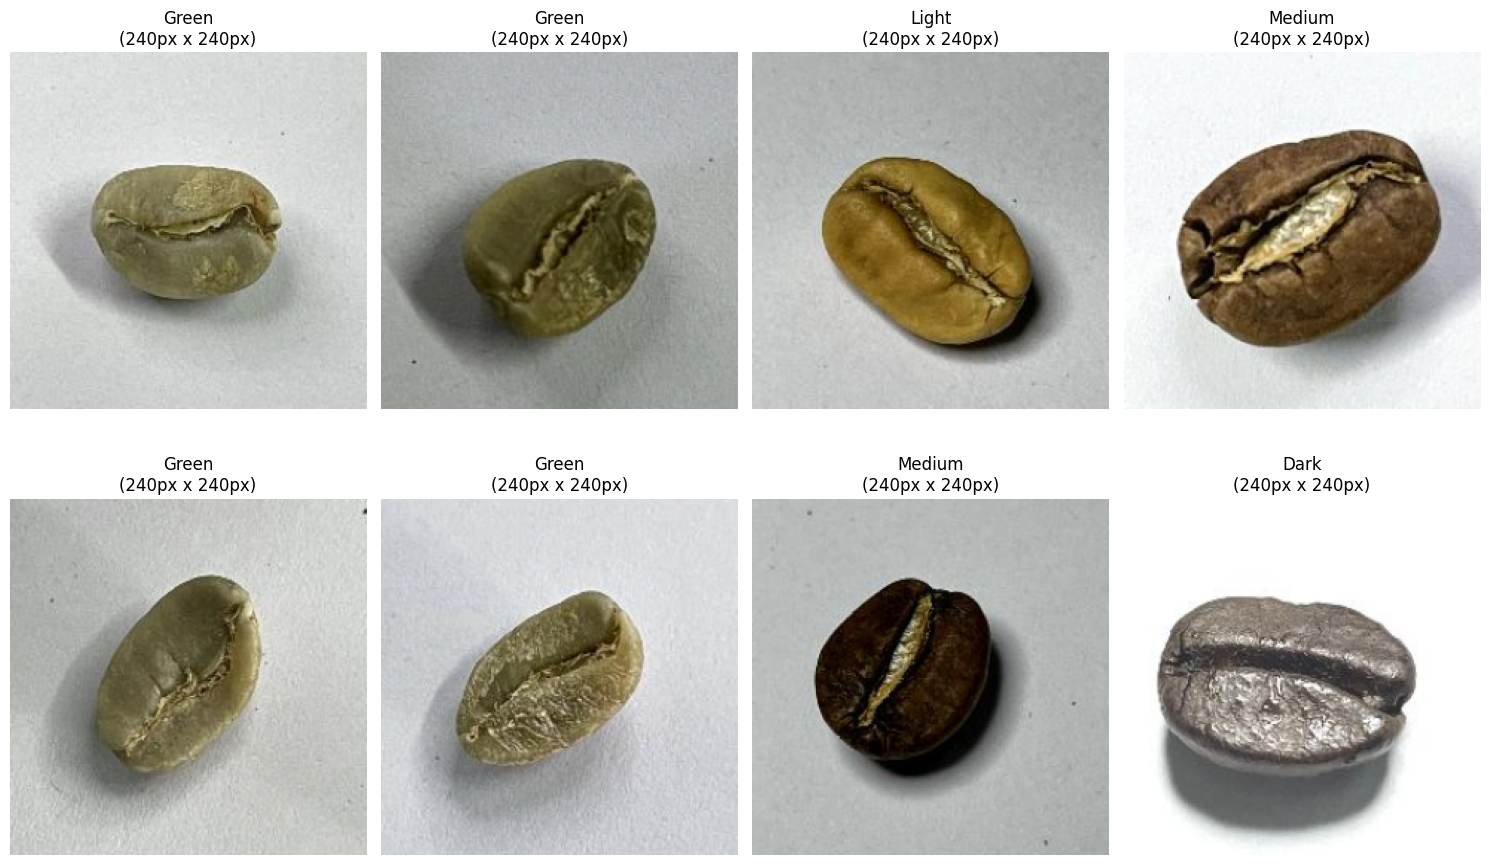

In [92]:
# Visualisasi 10 Dataset Secara Random
image_vizualize(x_train, y_train, 8, class_labels)

# Fungsi untuk Mempersiapkan Data untuk CNN

In [93]:
# Fungsi mempersiapkan data untuk training CNN
def data_preparation_training(training_path, validate_path, test_path, target_image_size):
    training = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    fill_mode='nearest',
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
    )
    
    training_generator = training.flow_from_directory(
        directory=training_path,
        target_size=target_image_size,
        batch_size=32,
        class_mode="categorical",
        classes=["Dark", "Green", "Light", "Medium"],
        shuffle=True
    )
    
    validate = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=False
    )

    validate_generator = validate.flow_from_directory(
        directory=validate_path,
        target_size=target_image_size,
        batch_size=32,
        class_mode="categorical",
        classes=["Dark", "Green", "Light", "Medium"],
        shuffle=True
    )

    test = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.resnet50.preprocess_input
    )

    test_generator = test.flow_from_directory(
        directory=test_path,
        target_size=target_image_size,
        batch_size=32,
        classes=["Dark", "Green", "Light", "Medium"],
        class_mode="categorical",
        shuffle=False
    )
    
    return training_generator, validate_generator, test_generator


In [94]:
# Panggil fungsi data_preparation_training
training_generator, validate_generator, test_generator = data_preparation_training(training_path, validate_path, test_path, target_image_size)

Found 2153 images belonging to 4 classes.
Found 238 images belonging to 4 classes.
Found 238 images belonging to 4 classes.


# Fungsi untuk Generate Data dan Train Model

In [196]:
# Fungsi untuk training model menggunakan ResNet50 dengan generator
def training_model(training_generator, validate_generator, epochs=30):
    
    # Menggunakan Adam optimizer dengan learning rate lebih rendah
    optimizer = Adam(learning_rate=1e-5)

    # Base model
    base_model = ResNet50(
        input_shape=(240, 240, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Membuat layer pada base_model menjadi tidak dapat dilatih
    for layer in base_model.layers:
        layer.trainable = False

    # Model architecture
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(units=256, activation='relu'),
        Dense(units=512, activation='relu'),
        Dropout(0.5), 
        Dense(units=4, activation='softmax')
    ])
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss', 
        patience=8, 
        restore_best_weights=True, 
        verbose=1
    )
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=3, 
        verbose=1
    )

    # Training
    history = model.fit(
        training_generator,
        validation_data=validate_generator,
        epochs=epochs,
        verbose=1,
        steps_per_epoch=len(training_generator),
        validation_steps=len(validate_generator),
        callbacks=[early_stopping, lr_scheduler]
    )
    return history, model

In [197]:
# List kosong untuk menyimpan values
training_metrics = []
validate_metrics = []
all_classification_reports = []
all_confusion_matrix = []

In [198]:
# Train the model
history, trained_model = training_model(training_generator, validate_generator, epochs=30)

Epoch 1/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.3279 - loss: 1.3799 - val_accuracy: 0.6303 - val_loss: 1.1502 - learning_rate: 1.0000e-05
Epoch 2/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.5295 - loss: 1.1153 - val_accuracy: 0.7857 - val_loss: 0.9461 - learning_rate: 1.0000e-05
Epoch 3/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.6591 - loss: 0.9315 - val_accuracy: 0.8655 - val_loss: 0.7821 - learning_rate: 1.0000e-05
Epoch 4/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.7733 - loss: 0.7642 - val_accuracy: 0.8866 - val_loss: 0.6610 - learning_rate: 1.0000e-05
Epoch 5/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8170 - loss: 0.6577 - val_accuracy: 0.9034 - val_loss: 0.5459 - learning_rate: 1.0000e-05
Epoch 6/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8579 - loss: 0.5598 - val_accuracy: 0.9202 - val_loss: 0.4535 - learning_rate: 1.0000e-05
Epoch 7/30
68/68 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8686 - loss:

In [199]:
# Collect metrics
training_metrics.append(history.history['accuracy'])
validate_metrics.append(history.history['val_accuracy'])

# Get predictions and true labels for validation data
validation_predictions = trained_model.predict(validate_generator, steps=len(validate_generator), verbose=1)
validation_predictions = np.argmax(validation_predictions, axis=1)
validation_labels = validate_generator.classes 

# Generate and store classification report and confusion matrix
classification_report_str = classification_report(validation_labels, validation_predictions, target_names=list(class_labels.keys()))
confusion_mtx = confusion_matrix(validation_labels, validation_predictions)


all_classification_reports.append(classification_report_str)
all_confusion_matrix.append(confusion_mtx)

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step


# Prediksi dan Simpan Hasil

In [200]:
# Fungsi untuk menyimpan hasil classification report dalam bentuk gambar
def save_classification_report_image(classification_report_str, destination_dir, is_final=False):
    if not is_final:
        plt_title = "Classification Report"
    else:
        plt_title = "Final Classification Report"

    full_path = os.path.join(destination_dir, f'{plt_title.lower().replace(" ", "_")}.png')
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    plt.figure(figsize=(8, 6))
    plt.text(0.2, 0.7, classification_report_str, fontsize=12, verticalalignment='center')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(full_path, bbox_inches='tight')
    plt.close()

# Fungsi untuk menyimpan hasil confusion matrix
def save_confusion_matrix_image(confusion_mtx, destination_dir, is_final=False):
    if not is_final:
        plt_title = "Confusion Matrix"
    else:
        plt_title = "Final Confusion Matrix"

    full_path = os.path.join(destination_dir, f'{plt_title.lower().replace(" ", "_")}.png')
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_mtx, interpolation="nearest", cmap=plt.cm.Oranges)
    plt.title(plt_title)
    plt.colorbar()
    tick_marks = np.arange(len(class_labels.keys()))
    plt.xticks(tick_marks, class_labels.keys(), rotation=45, ha='right')
    plt.yticks(tick_marks, class_labels.keys())
    fmt = ".2f" if False else "d"
    thresh = confusion_mtx.max() / 2.
    for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
        plt.text(j, i, format(confusion_mtx[i, j], fmt), horizontalalignment="center",
                color="white" if confusion_mtx[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True Labels", fontweight="bold")
    plt.xlabel("Predicted Labels", fontweight="bold")
    plt.savefig(full_path, bbox_inches='tight')
    plt.close()

# Fungsi untuk menyimpan plot Training dan Validation Accuracy
def save_training_validation_accuracy(history, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    accuracy_plot_path = os.path.join(destination_dir, 'training_validation_accuracy.png')
    plt.savefig(accuracy_plot_path)
    plt.close()

# Fungsi untuk menyimpan plot Training dan Validation Loss
def save_training_validation_loss(history, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)
    
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    loss_plot_path = os.path.join(destination_dir, 'training_validation_loss.png')
    plt.savefig(loss_plot_path)
    plt.close()

In [201]:
# Folder penyimpanan untuk classification report
destination_dir_classification = r"training_results/scene_6"

# Folder penyimpanan untuk confusion matrix
destination_dir_confusion = r"training_results/scene_6"

# Folder penyimpanan untuk grafik akurasi dan loss
destination_dir_plots = r"training_results/scene_6"

In [202]:
# Simpan classification reports sebagai gambar
for i, classification_report_str in enumerate(all_classification_reports):
    save_classification_report_image(classification_report_str, destination_dir_classification, is_final=False)

In [203]:
# Simpan confusion matrices sebagai gambar
for i, confusion_mtx in enumerate(all_confusion_matrix):
    save_confusion_matrix_image(confusion_mtx, destination_dir_confusion, is_final=False)

In [204]:
# Lakukan prediksi pada data test dengan generator
test_predictions = trained_model.predict(test_generator, steps=len(test_generator), verbose=1)
test_predictions = np.argmax(test_predictions, axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


In [205]:
# Hitung dan cetak classification report akhir
test_labels = test_generator.classes
final_classification_report = classification_report(test_labels, test_predictions, target_names=list(class_labels.keys()))
print(f"Final Classification Report\n")
print(final_classification_report)


Final Classification Report

              precision    recall  f1-score   support

        Dark       0.95      1.00      0.97        58
       Green       0.99      1.00      0.99        68
       Light       1.00      0.98      0.99        56
      Medium       1.00      0.95      0.97        56

    accuracy                           0.98       238
   macro avg       0.98      0.98      0.98       238
weighted avg       0.98      0.98      0.98       238



In [206]:
# Simpan classification report akhir sebagai gambar
save_classification_report_image(final_classification_report, destination_dir_classification, is_final=True)

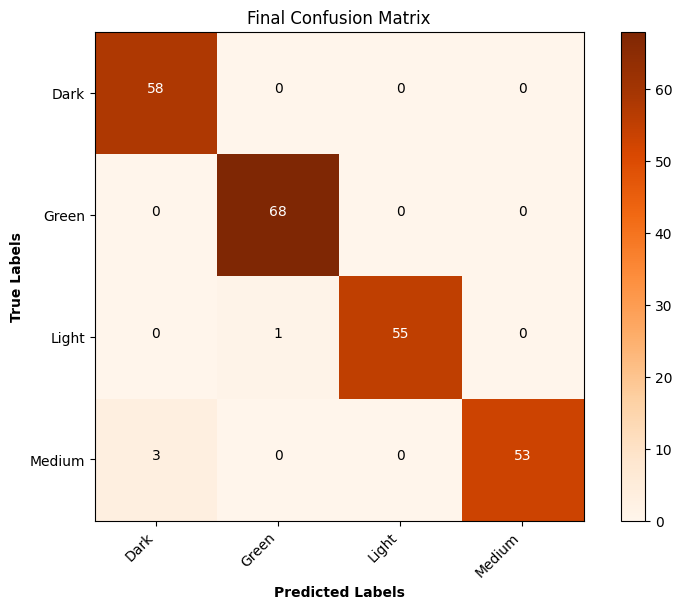

In [207]:
# Final confusion matrix
final_confusion_mtx = confusion_matrix(test_labels, test_predictions)

# Plot final confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(final_confusion_mtx, interpolation="nearest", cmap=plt.cm.Oranges)
plt.title("Final Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels.keys()))
plt.xticks(tick_marks, class_labels.keys(), rotation=45, ha='right')
plt.yticks(tick_marks, class_labels.keys())
fmt = ".2f" if False else "d"
thresh = final_confusion_mtx.max() / 2.
for i, j in itertools.product(range(final_confusion_mtx.shape[0]), range(final_confusion_mtx.shape[1])):
    plt.text(j, i, format(final_confusion_mtx[i, j], fmt), horizontalalignment="center",
             color="white" if final_confusion_mtx[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel("True Labels", fontweight="bold")
plt.xlabel("Predicted Labels", fontweight="bold")
plt.show()

In [208]:
# Simpan final confusion matrix sebagai gambar
final_confusion_mtx = confusion_matrix(test_labels, test_predictions)
save_confusion_matrix_image(final_confusion_mtx, destination_dir_confusion, is_final=True)

In [209]:
# Fungsi untuk menampilkan plot Training dan Validation Accuracy
def plot_training_validation_accuracy(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

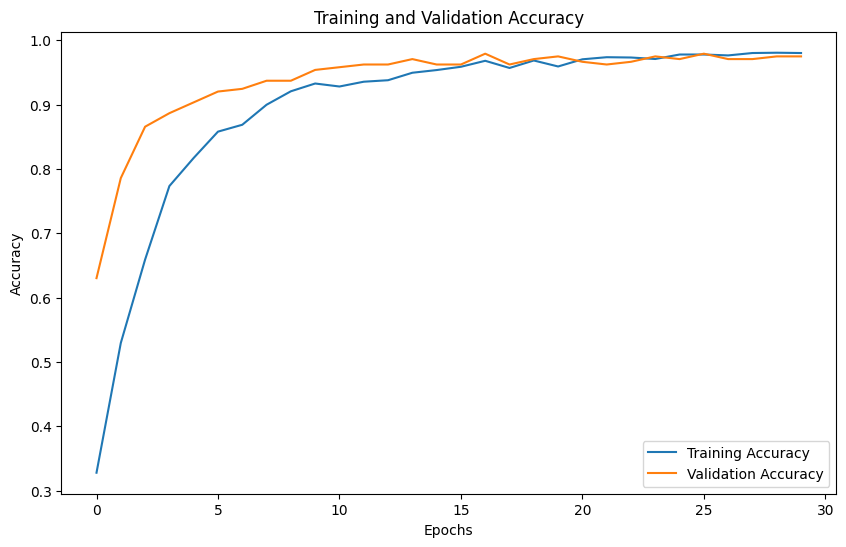

In [210]:
# Panggil fungsi untuk menampilkan plot Training dan Validation Accuracy
plot_training_validation_accuracy(history)

In [211]:
# Fungsi untuk menampilkan plot Training dan Validation Loss
def plot_training_validation_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

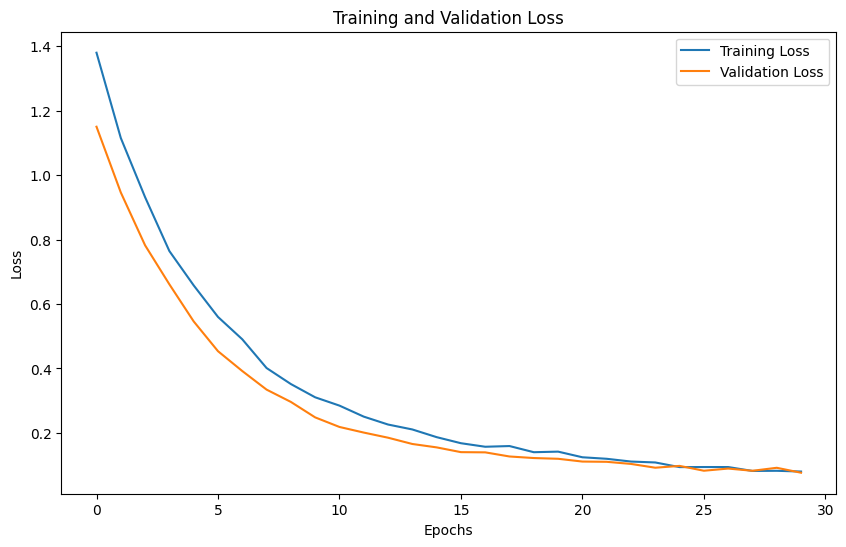

In [212]:
# Panggil fungsi untuk menampilkan plot Training dan Validation Loss
plot_training_validation_loss(history)

In [213]:
# Menyimpan plot training_validasi_loss sebagai gambar
save_training_validation_accuracy(history, destination_dir_plots)
save_training_validation_loss(history, destination_dir_plots)

# Simpan Model

In [214]:
# Save model
trained_model.save("training_results/scene_6/model_cnn_6.h5")
print("Model telah berhasil disimpan")

Model telah berhasil disimpan


In [215]:
# Tampilkan berat model
print(f"Berat model : {os.path.getsize('training_results/scene_6/model_cnn_6.h5') / 1e6:.2f} MB")

Berat model : 102.66 MB
